# This notebook will demonstrate Superman on a swiss roll and s curve

Make sure to set the kernel to the poetry environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from src.geometry import Points
from src.geometry.matrix import LaplacianMatrix
from src.geometry.embedding import laplacian_embedding
from src.data import load_swiss_roll, load_s_curve

: 

We first load the swiss roll which returns a Tuple of `Points` and `Coordinates`, custom Superman objects.

In [ ]:
#returns tuple of points and intrinsic parameter
points_coords = load_swiss_roll(1000)
points = points_coords[0]
coords = points_coords[1]

The `Points` objects lets you call `pairwise_distance` which will return a `DistanceMatrix` object. You can select different distance metrics which will be stored in the `metadata` field of the resulting `DistanceMatrix` object. Future methods use this metadata to select the correct/efficient calculation. You can modify the metadata directly, but this is not recommended. You can also cast all Superman matrices to numpy arrays.

In [ ]:
#get the pairwise distance matrix with cityblock metric
dist = points.pairwise_distance(dist_type="cityblock")
print(dist.metadata)
#get the pairwise distance matrix with default euclidian metric
dist = points.pairwise_distance()
print(dist.metadata)
dist_arr = dist.as_nparray()
print(type(dist_arr))

Metadata(name=None, dist_type='cityblock', aff_type=None, lap_type=None, radius=None, eps=None, ks=None, radii=None, ds=None, degree_type=None, aff_minus_id=None)
Metadata(name=None, dist_type='euclidean', aff_type=None, lap_type=None, radius=None, eps=None, ks=None, radii=None, ds=None, degree_type=None, aff_minus_id=None)
<class 'numpy.ndarray'>


You can also create a `LaplacianMatrix`, `DistanceMatrix` or any other matrix with any array-like object. They will also inherit the metadata of the array like object if it has metadata. Any extra kwargs will be interpreted as metadata fields.

In [ ]:
#you can use any array-like but it will not inherit the metadata if there is no metadata
temp = LaplacianMatrix.create(np.random.rand(10,10))
print(temp)
#`euclidian` metadata is inherited
temp = LaplacianMatrix.create(dist)
print(temp.metadata)
#kwarg results in metadata field
temp = LaplacianMatrix.create(points, lap_type="geometric")
print(temp.metadata)

DenseArray: 
  - shape: (10, 10) 
  - dtype: <class 'numpy.float64'> 
  - data: Storage(array([[0.66184636, 0.52854986, 0.08700047, 0.77015909, 0.11230306,
        0.73269794, 0.73557121, 0.89604139, 0.48945844, 0.48281056],
       [0.51521285, 0.53045373, 0.82409711, 0.09753941, 0.68707756,
        0.91477393, 0.50451744, 0.67860964, 0.26059959, 0.38123803],
       [0.34445576, 0.03482842, 0.9377001 , 0.94079926, 0.56302522,
        0.81520396, 0.50325557, 0.73979237, 0.00236042, 0.73120591],
       [0.62601583, 0.58157013, 0.34690983, 0.84743378, 0.87627675,
        0.82632927, 0.69485722, 0.47900544, 0.65343744, 0.46572698],
       [0.45653846, 0.7938299 , 0.32878909, 0.11696845, 0.12596694,
        0.60474605, 0.75387394, 0.3226294 , 0.20753588, 0.69635086],
       [0.06090828, 0.67058212, 0.43076492, 0.63423873, 0.66563198,
        0.81990335, 0.27910841, 0.09121239, 0.1374199 , 0.4388319 ],
       [0.87543751, 0.30559327, 0.0307331 , 0.28743867, 0.74929554,
        0.54231289, 0.

You can call most instance methods as a class method.

In [ ]:
#call with class function
dist = Points.pairwise_distance(points)
print(dist)

DenseArray: 
  - shape: (1000, 1000) 
  - dtype: <class 'numpy.float64'> 
  - data: Storage(array([[ 0.        , 14.48145046, 23.46896725, ...,  6.37025419,
        12.22140937, 16.10830238],
       [14.48145046,  0.        , 13.1353079 , ..., 15.53003717,
        12.21301926, 13.7359653 ],
       [23.46896725, 13.1353079 ,  0.        , ..., 24.18739708,
        19.50853554, 22.15535522],
       ...,
       [ 6.37025419, 15.53003717, 24.18739708, ...,  0.        ,
         7.84951327, 11.55604897],
       [12.22140937, 12.21301926, 19.50853554, ...,  7.84951327,
         0.        ,  5.56403491],
       [16.10830238, 13.7359653 , 22.15535522, ..., 11.55604897,
         5.56403491,  0.        ]], shape=(1000, 1000)))


Many functions have the `in-place` parameter which will execute the operation on the underlying data without reallocating memory (this is the most efficient).

In [ ]:
#threshold in-place by a carefully chosen epsilon
dist.threshold(6.54, in_place=True)

DenseArray: 
  - shape: (1000, 1000) 
  - dtype: <class 'numpy.float64'> 
  - data: Storage(array([[0.        ,        inf,        inf, ..., 6.37025419,        inf,
               inf],
       [       inf, 0.        ,        inf, ...,        inf,        inf,
               inf],
       [       inf,        inf, 0.        , ...,        inf,        inf,
               inf],
       ...,
       [6.37025419,        inf,        inf, ..., 0.        ,        inf,
               inf],
       [       inf,        inf,        inf, ...,        inf, 0.        ,
        5.56403491],
       [       inf,        inf,        inf, ...,        inf, 5.56403491,
        0.        ]], shape=(1000, 1000)))

We can then compute the embedding with a few numpy-style function calls. Methods are type-hinted and have documentation in addition to being type safe (laplacian types like "geometric" are all bound to the `LaplacianType` literal). All execution semantics (e.g. how addition happens) are abstracted away, allowing the package to decide things like dense vs. sparse execution without requiring user attention. All information about type of affinity, type of laplacian and type of distance is stored in the `metadata` field of each object and is used automatically by functions.

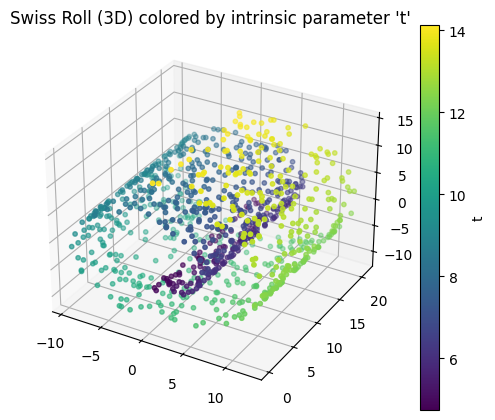

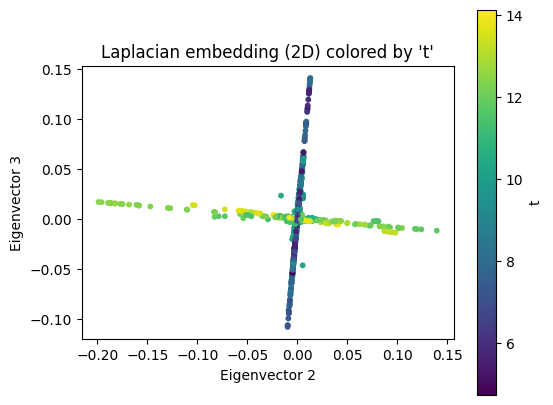

In [ ]:
#use the default gaussian affinity
aff = dist.affinity()
#we can calculate the laplacian embedding directly from the affinity (calculates the laplacian in an efficient manner)
emb = laplacian_embedding(aff, ncomp=2, lap_type="geometric", drop_first=True, eigen_solver="dense")
emb_vec = emb[1]
#you can cast all Superman objects back to np arrays
np_points = points.as_nparray()
np_coords = coords.as_nparray()

#plotting utility coming soon
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(np_points[:,0], np_points[:,1], np_points[:,2], c=points_coords[1].as_nparray(), s=10)
ax.set_title("Swiss Roll (3D) colored by intrinsic parameter 't'")
plt.colorbar(sc, label="t")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(emb_vec[:,0], emb_vec[:,1], c=points_coords[1].as_nparray(), s=10)
plt.xlabel("Eigenvector 2")
plt.ylabel("Eigenvector 3")
plt.title("Laplacian embedding (2D) colored by 't'")
plt.colorbar(label="t")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We do the same for an s curve.

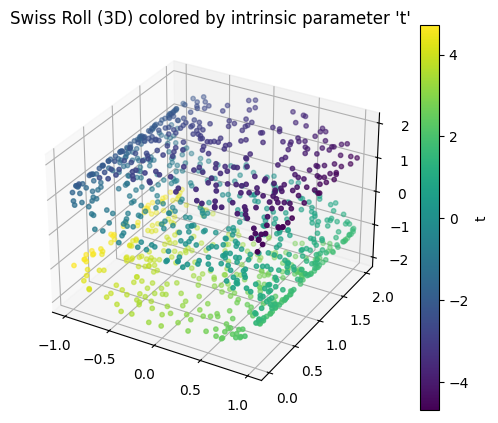

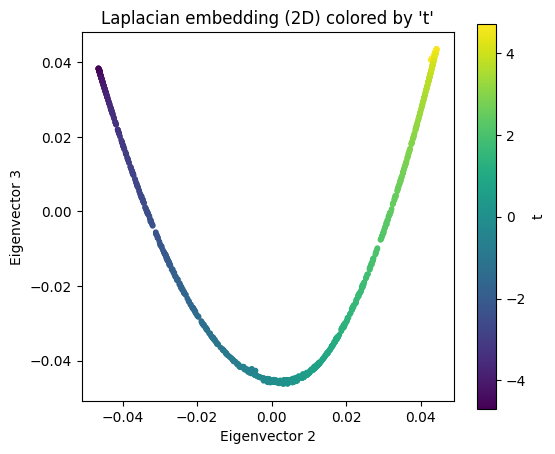

In [ ]:
points_coords = load_s_curve(1000)
points = points_coords[0]
dist = points.pairwise_distance()
dist.threshold(1.27, in_place=True)
aff = dist.affinity()
emb = laplacian_embedding(aff, ncomp=2, lap_type="geometric", drop_first=True, eigen_solver="dense")
emb_vec = emb[1]
np_points = points.as_nparray()

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(np_points[:,0], np_points[:,1], np_points[:,2], c=points_coords[1].as_nparray(), s=10)
ax.set_title("Swiss Roll (3D) colored by intrinsic parameter 't'")
plt.colorbar(sc, label="t")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(emb_vec[:,0], emb_vec[:,1], c=points_coords[1].as_nparray(), s=10)
plt.xlabel("Eigenvector 2")
plt.ylabel("Eigenvector 3")
plt.title("Laplacian embedding (2D) colored by 't'")
plt.colorbar(label="t")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()